In [81]:
from my_utils.stardisting import load_published_he_model
from my_utils import tile_processing as tp

from stardist.bioimageio_utils import normalize
from stardist.matching import matching_dataset as scorer
import os
from tqdm import tqdm
import pandas as pd

In [82]:
def write_row(column_names, values, df):
    row = pd.DataFrame(pd.Series(index=column_names)).T
    for c, col_name in enumerate(column_names):
        row[col_name] = values[c]
    return pd.concat([df, row], ignore_index=True, axis=0)

In [83]:
base_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets"

In [84]:
model_name = '2D_versatile_he'
model = load_published_he_model(
    folder_to_write_new_model_folder=os.path.join(base_folder, "Segmentation Models\StarDist"),
    name_for_new_model=model_name)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Using default values: prob_thresh=0.5, nms_thresh=0.4.

Ignore that, thresholds are: Thresholds(prob=0.6924782541382084, nms=0.3)


base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\Segmentation Models\StarDist\2D_versatile_he


In [85]:
upsampling_base_folder = os.path.join(base_folder, "40x Upsampled")
upsampling_folders = os.listdir(upsampling_base_folder)

In [86]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
columns = ['Model', 'Input Scaling', 'Dataset', 'Tile', 'Tau', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score', 'Panoptic Quality']
df_scores = pd.DataFrame(columns=columns)

In [87]:
for upsample in tqdm(upsampling_folders, desc='Upsample', position=1, leave=False):
# for upsample in [upsampling_folders[8]]:
    datasets_base_folder = os.path.join(upsampling_base_folder, upsample)
    for dataset in tqdm(os.listdir(datasets_base_folder), desc='Dataset', position=2, leave=False):
    # for dataset in [os.listdir(datasets_base_folder)[0]]:
        tile_folder = os.path.join(datasets_base_folder, dataset + r"\images")
        gt_folder = os.path.join(datasets_base_folder, dataset + r"\masks")
        tile_sets = tp.TileSetReader([tile_folder, gt_folder], ['.tif', '.tif']).tile_sets
        # [0]-basenames, [1][0]-images, [1][1]-gt, [1][2]-pred
        tile_sets[1].append([])
        for i, img in enumerate(tile_sets[1][0]):
        # for i, img in enumerate([tile_sets[1][0][0]]):
            img = normalize(img, pmin=1, pmax=99.8, axis=(0, 1, 2))
            pred, _ = model.predict_instances(img)
            tile_sets[1][2].append(pred)
            gt = tile_sets[1][1][i]
            for tau in taus:
            # for tau in [taus[0]]:
                scores = scorer([gt], [pred], thresh=tau, show_progress=False)._asdict()
                values = [model_name, upsample, dataset, tile_sets[0][i], tau,
                          scores['tp'], scores['fp'], scores['fn'],
                          scores['precision'], scores['recall'], scores['f1'], scores['panoptic_quality']]
                df_scores = write_row(columns, values, df_scores)
            


Upsample:   0%|          | 0/13 [00:00<?, ?it/s]

Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Dataset:  25%|██▌       | 1/4 [00:22<01:07, 22.61s/it]

Dataset:  50%|█████     | 2/4 [00:29<00:27, 13.65s/it]

Dataset:  75%|███████▌  | 3/4 [01:02<00:22, 22.35s/it]

Dataset: 100%|██████████| 4/4 [01:14<00:00, 18.17s/it]

                                                      
Upsample:   8%|▊         | 1/13 [01:14<14:53, 74.45s/it]

Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Dataset:  25%|██▌       | 1/4 [00:23<01:10, 23.55s/it]

Dataset:  50%|█████     | 2/4 [00:30<00:28, 14.08s/it]

Dataset:  75%|███████▌  | 3/4 [01:05<00:23, 23.37s/it]

Dataset: 100%|██████████| 4/4 [01:16<00:00, 18.39s/it]

                                                      
Upsample:  15%|█▌        | 2/13 [02:30<13:50, 75.46s/it]

Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Dataset:  25%|██▌       | 1/4 [00:23<01:09, 23.04s/it]

Dataset:  50%|█████     | 2/4 [00:30<00:28, 14.09s/it]

Dataset:  75%|█████

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

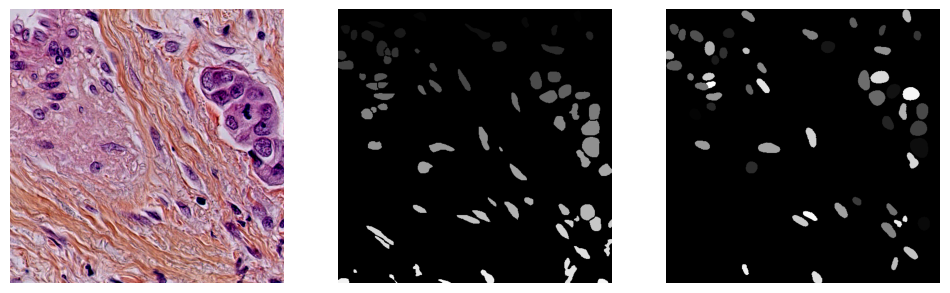

In [88]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed
axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[1].imshow(gt, cmap='gray')
axs[1].axis('off')
axs[2].imshow(pred, cmap='gray')
axs[2].axis('off')

In [89]:
df_scores

,Model,Input Scaling,Dataset,Tile,Tau,TP,FP,FN,Precision,Recall,F1-Score,Panoptic Quality
0,2D_versatile_he,00 - Nearest Neighbor - Nearest Neighbor,CoNSeP,test_1,0.1,287,25,571,0.919872,0.334499,0.490598,0.111012
1,2D_versatile_he,00 - Nearest Neighbor - Nearest Neighbor,CoNSeP,test_1,0.2,172,140,686,0.551282,0.200466,0.294017,0.081077
2,2D_versatile_he,00 - Nearest Neighbor - Nearest Neighbor,CoNSeP,test_1,0.3,48,264,810,0.153846,0.055944,0.082051,0.028295
3,2D_versatile_he,00 - Nearest Neighbor - Nearest Neighbor,CoNSeP,test_1,0.4,5,307,853,0.016026,0.005828,0.008547,0.003928
4,2D_versatile_he,00 - Nearest Neighbor - Nearest Neighbor,CoNSeP,test_1,0.5,1,311,857,0.003205,0.001166,0.001709,0.000920
...,...,...,...,...,...,...,...,...,...,...,...,...
16285,2D_versatile_he,__ - 40x Native,TNBC,11_3,0.5,54,2,24,0.964286,0.692308,0.805970,0.633313
16286,2D_versatile_he,__ - 40x Native,TNBC,11_3,0.6,52,4,26,0.928571,0.666667,0.776119,0.616896
16287,2D_versatile_he,__ - 40x Native,TNBC,11_3,0.7,47,9,31,0.839286,0.602564,0.701493,0.566914
16288,2D_versatile_he,__ - 40x Native,TNBC,11_3,0.8,27,29,51,0.482143,0.346154,0.402985,0.344977


In [90]:
out_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\Segmentation Scores\2D_versatile_he"
df_scores.to_csv(os.path.join(out_folder, '40x_Scoring.csv'), index=False)